In [1]:
import numpy as np
from common import *

import os, time
import tflearn
from io import StringIO
import copy
import pickle
from functools import partial
import train
import data_flow
from data_flow import nameit

from __future__ import division
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances

# Prepare word vectors

In [2]:
w2v_model = Word2Vec.load(join(DATA_FOLDER, 'vectors/w2v_model_300_w10'))

2017-09-08 19:14:42,298 [MainThread  ] [INFO ]  loading Word2Vec object from ../data/vectors/w2v_model_300_w10
2017-09-08 19:14:44,446 [MainThread  ] [INFO ]  loading wv recursively from ../data/vectors/w2v_model_300_w10.wv.* with mmap=None
2017-09-08 19:14:44,447 [MainThread  ] [INFO ]  loading syn0 from ../data/vectors/w2v_model_300_w10.wv.syn0.npy with mmap=None
2017-09-08 19:14:44,594 [MainThread  ] [INFO ]  setting ignored attribute syn0norm to None
2017-09-08 19:14:44,595 [MainThread  ] [INFO ]  loading syn1neg from ../data/vectors/w2v_model_300_w10.syn1neg.npy with mmap=None
2017-09-08 19:14:44,736 [MainThread  ] [INFO ]  setting ignored attribute cum_table to None
2017-09-08 19:14:44,737 [MainThread  ] [INFO ]  loaded ../data/vectors/w2v_model_300_w10


In [21]:
word_embeddings = w2v_model.wv.syn0.copy()
index2word = copy.deepcopy(w2v_model.wv.index2word)
del w2v_model

In [22]:
index2word.insert(0, 'PAD')
with open(join(DATA_FOLDER, "dictionary.pickle"), "wb") as output_file:
    pickle.dump(index2word, output_file)

In [17]:
stds = np.apply_along_axis(np.std, 1, word_embeddings)
pd.Series(stds).describe()

count    680760.000000
mean          0.193705
std           0.070574
min           0.000910
25%           0.137368
50%           0.178099
75%           0.244486
max           0.744395
dtype: float64

In [18]:
# 0.34 is chosen so the unknown vectors have (approximately) same variance as pre-trained ones
pad_vec = np.random.uniform(-0.34,0.34, word_embeddings.shape[1])
np.std(pad_vec)

0.20150940312078128

In [19]:
word_embeddings = np.insert(word_embeddings, 0, pad_vec, axis=0)

In [20]:
np.save(join(DATA_FOLDER, 'word_embeddings_%s.npy' % word_embeddings.shape[1]), word_embeddings)

# Load input data

In [2]:
word_embeddings = np.load(join(DATA_FOLDER, 'word_embeddings_300.npy'))
with open(join(DATA_FOLDER, "dictionary.pickle"), "rb") as input_file:
    index2word = pickle.load(input_file)

In [3]:
ids = glob('../data/corpus/**.txt')
with open(join(DATA_FOLDER, 'sims.json'), 'r') as f:
    sims = json.load(f)

In [4]:
triples_all = list(data_flow.random_triples(sims, ids, num_epochs=1, seed=1))
_triples, triples_test = train_test_split(triples_all, test_size=0.1, random_state=0)
triples_train, triples_val = train_test_split(_triples, test_size=0.1, random_state=0)

print(len(triples_train), len(triples_val), len(triples_test))

100%|██████████| 368458/368458 [00:07<00:00, 47924.28it/s]


(619669, 68853, 76503)


In [5]:
# triples_all = pd.read_csv(join(DATA_FOLDER, 'mpk_flow.csv.gz'), sep=' ', header=None)
# triples_all = triples_all[triples_all[2] != '59a969f1782b1b893a912539']

In [7]:
# triples_train, triples_val, triples_test = [], [], []
# for epoch_data in np.array_split(triples_all, 3)[:1]:
#     _triples, _test = train_test_split(epoch_data, test_size=0.1, random_state=0, shuffle=False)
#     _train, _val = train_test_split(_triples, test_size=0.1, random_state=0, shuffle=False)

#     triples_train += [[nameit(a), nameit(b), nameit(c)] for a,b,c in _train.values]
#     triples_val += [[nameit(a), nameit(b), nameit(c)] for a,b,c in _val.values]
#     triples_test += [[nameit(a), nameit(b), nameit(c)] for a,b,c in _test.values]
    
# logging.info('train %s val %s test %s' % (len(triples_train), len(triples_val), len(triples_test)))

In [5]:
vocab_size, embedding_size = word_embeddings.shape
n_sents, n_words = 123, 40
batch_size = 64
num_epochs = 1
learning_rate = 0.001

sent_filter_sizes = [1, 2, 3, 4, 5]
sent_nb_filter = 10
sent_embed_size = 128
sent_kmax = 4

doc_filter_sizes = [1, 2, 3, 4, 5]
doc_nb_filter = 10
doc_embed_size = 200
doc_kmax = 4

# Train

In [ ]:
reload(train)

logging.info('start training ...')
start_time = time.time()

finished = False
try:
    tf.reset_default_graph()
    tf.set_random_seed(0)
    session_conf = tf.ConfigProto(
        allow_soft_placement=True, log_device_placement=False)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        X, fnames_batch = data_flow.input_pipeline(
            triples_train[:batch_size*3], [n_sents, n_words], 
            batch_size=batch_size, num_epochs=num_epochs)

        model = train.TextCNN(
            n_sents,
            n_words,
            vocab_size,
            embedding_size,
            batch_size,
            sent_filter_sizes=sent_filter_sizes,
            sent_nb_filter=sent_nb_filter,
            sent_embed_size=sent_embed_size,
            doc_filter_sizes=doc_filter_sizes,
            doc_nb_filter=doc_nb_filter,
            doc_embed_size=doc_embed_size,
            sent_kmax=sent_kmax,
            doc_kmax=doc_kmax,
            learning_rate=learning_rate)
        train_op = model.optimize(X)

        init_local = tf.local_variables_initializer()
        init_global = tf.global_variables_initializer()
        sess.run([init_global, init_local])

        model.init_summary()
        #!!!! index is shifted by 1
        model.init_lookup_table(word_embeddings)

#         pprint([n.name for n in tf.get_default_graph().as_graph_def().node])

        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)

        try:
            while not coord.should_stop():
                _, step, loss, summary, _emb = sess.run([
                    train_op, model.global_step, model.loss_op,
                    model.merged_summary_op, model.doc_embed_normalized
                ], feed_dict = {model.phase: 1})
                model.add_summary(summary, step)
                logging.info('step %s, loss %s' % (step, loss))
        except tf.errors.OutOfRangeError:
            logging.info('Done training -- epoch limit reached')
        finally:
            # When done, ask the threads to stop.
            coord.request_stop()

        # Wait for threads to finish.
        coord.join(threads)
        model.save(step)
        finished = True

except Exception as e:
    logging.exception("train error")
    send_email('notebook_url', subject='train error', body=e)
finally:
    if finished:
#         send_email('notebook_url', subject='finished training')
        pass
        
logging.info("--- %s seconds ---" % (time.time() - start_time))

# Test

In [6]:
model_dir = join(DATA_FOLDER, 'models')
!ls {model_dir+'/*.meta'}

../data/models/2017-09-26 11:15:09.052459-59.meta
../data/models/2017-09-26 11:15:29.820761-99.meta
../data/models/2017-09-26 11:15:56.925237-119.meta
../data/models/2017-09-26 11:16:17.511134-129.meta
../data/models/2017-09-26 11:16:31.954300-139.meta
../data/models/2017-09-26 11:16:46.771881-149.meta
../data/models/2017-09-26 11:16:59.498404-159.meta
../data/models/2017-09-26 11:17:36.095400-160.meta
../data/models/2017-09-26 11:17:56.311153-161.meta
../data/models/2017-09-26 11:18:11.756090-162.meta
../data/models/2017-09-26 11:21:17.669527-162.meta
../data/models/2017-09-26 11:22:00.079404-199.meta
../data/models/2017-09-26 11:22:14.470317-199.meta
../data/models/2017-09-26 11:22:44.619330-160.meta
../data/models/2017-09-26 11:23:07.798019-160.meta
../data/models/2017-09-26 11:23:21.365907-161.meta
../data/models/2017-09-26 12:09:13.085158-161.meta
../data/models/2017-09-26 12:30:52.304624-999.meta
../data/models/2017-09-26 12:46:51.576442-999.meta
../data/models/2017-09-26 12:51:1

In [7]:
def last_model(model_dir):
    fnames = glob(join(model_dir, '*.meta'))
    return max(fnames)

In [9]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

chunked = list(chunks(ids, 3))
print(chunked.pop())
logging.info('len(chunked) = %s' % len(chunked))

2017-09-18 14:31:14,113 [MainThread  ] [INFO ]  len(chunked) = 422394


['../data/corpus/5984b84fb6b1132eeb638535.txt']


https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/4_Utils/save_restore_model.py

In [10]:
doc_embeds, fnames = [], []

In [10]:
finished = False
try:
    tf.reset_default_graph()
    tf.set_random_seed(0)
    session_conf = tf.ConfigProto(
        allow_soft_placement=True, log_device_placement=False)
    sess = tf.Session(config=session_conf)    
    with sess.as_default():
        X, fnames_batch = data_flow.input_pipeline(
            chunked[:batch_size*100], [n_sents, n_words], batch_size=batch_size, 
            num_epochs=1, shuffle=False)

        init_local = tf.local_variables_initializer()
        init_global = tf.global_variables_initializer()
        sess.run([init_global, init_local])

        # do not restore before global initialization, otherwise all weights are set to default !!!
        saver = tf.train.import_meta_graph(last_model(model_dir), input_map={'X':X})
        saver.restore(sess, tf.train.latest_checkpoint(model_dir))
        graph = tf.get_default_graph()

        op_name = 'optimize/loss/doc_embed_normalized'
        doc_embed_normalized = graph.get_operation_by_name(op_name).outputs[0]

        anchor, positive, negative = tf.unstack(
            tf.reshape(doc_embed_normalized, [-1, 3, doc_kmax * doc_nb_filter * len(doc_filter_sizes)]),
            3, 1)
        _loss = cnn.triplet_loss(anchor, positive, negative)

#         pprint([n.name for n in tf.get_default_graph().as_graph_def().node])

        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)

        step = 0
        try:
            while not coord.should_stop():
                [batch_embeds, loss, _names] = sess.run([doc_embed_normalized, 
                                                         _loss, fnames_batch])
                doc_embeds.append(batch_embeds)
                fnames += list(_names)
                logging.info('step %s, loss %s' % (step, loss))
                step+=1
        except tf.errors.OutOfRangeError:
            logging.info('Done testing -- epoch limit reached')
        finally:
            # When done, ask the threads to stop.
            coord.request_stop()

        # Wait for threads to finish.
        coord.join(threads)
        finished = True
        
except Exception as e:
    logging.exception("test error")
#     send_email('notebook_url', subject='test error', body=e)
finally:
    if finished:
#         send_email('notebook_url', subject='finished testing')
        pass

SyntaxError: invalid syntax (<ipython-input-10-3fb362e3db47>, line 3)

In [12]:
fnames = np.concatenate(fnames)
doc_embeds_reshaped = np.reshape(np.concatenate(doc_embeds), [-1, doc_embed_size])

ValueError: need at least one array to concatenate

In [8]:
margin = 0.5

In [14]:
# np.save('../data/doc_embeds_reshaped_1ep.npy', doc_embeds_reshaped)
# np.save('../data/fnames_1ep.npy', fnames)

In [9]:
doc_embeds_reshaped = np.load('../data/saved/doc_embeds_reshaped_1ep_%s.npy' % margin)
fnames = np.load('../data/saved/fnames_1ep_%s.npy' % margin)

In [10]:
np.save('../data/saved/fnames_1ep_%s.npy' % margin, [basename(n).split('.')[0] for n in fnames])

In [10]:
len(fnames)

1267008

# Get statistics

In [11]:
def predict(keys, lim=200):
    names = pd.Series(range(len(fnames)), index = fnames)
    test_vecs = []
    for k in keys:
        ix = names[k]
        if isinstance(ix, pd.Series):
            ix = ix[0]
        tvec = doc_embeds_reshaped[ix]
        test_vecs.append(tvec)

    dists = euclidean_distances(test_vecs, doc_embeds_reshaped)
    sorted_ixs = np.argsort(dists, axis=1)
    preds = {}
    for k, _ixs in zip(keys, sorted_ixs):
        preds[k] = [n for n in fnames[_ixs[1:lim+1]]]
        
    return preds

In [12]:
with open(join(DATA_FOLDER, 'gold_mongo.json'), 'r') as f:
    gold = json.load(f)

In [13]:
preds = predict(gold.keys(), lim=200)

100%|██████████| 184/184 [00:00<00:00, 24341.65it/s]


median
acc10     0.0
acc20     0.0
acc200    0.0
dtype: float64
mean
acc10     0.077899
acc20     0.125000
acc200    0.309511
dtype: float64


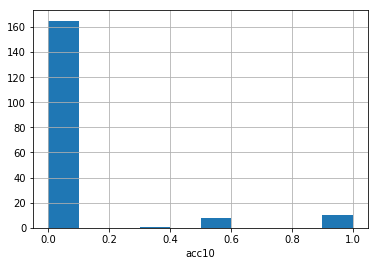

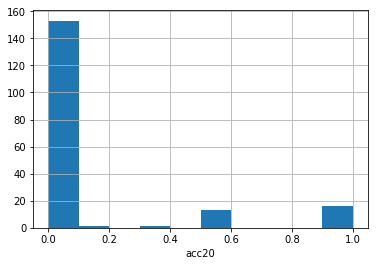

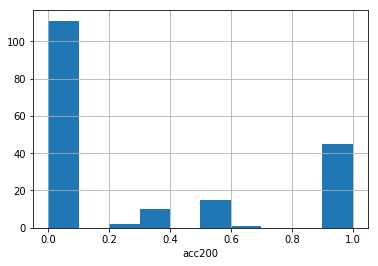

In [14]:
result = evaluate(preds, gold)

ax = result['acc10'].hist()
ax.set_xlabel("acc10")
plt.show()

ax = result['acc20'].hist()
ax.set_xlabel("acc20")
plt.show()

ax = result['acc200'].hist()
ax.set_xlabel("acc200")
plt.show()

In [30]:
sum([len(v) for v in gold.values()])

279

In [31]:
len(gold)

184

In [15]:
# k = preds.keys()[0]
k = '59a7bc6a782b1b893a56a87e'
print(k)
preds[k]

59a7bc6a782b1b893a56a87e


['5984cf94b6b11336826384f7',
 '5984dd6ab6b11333bc63853a',
 '5984cafdb6b1130a92638524',
 '5984cfa1b6b113368d63854e',
 '5984d036b6b1133d176384ff',
 '5984c5b8b6b11354246384f7',
 '5984de4bb6b1133908638508',
 '5984ba5db6b1134c2f638526',
 '5984d412b6b11363a16384fe',
 '5984c686b6b11359ab63854f',
 '5984dae5b6b1131d4e63852d',
 '5984de60b6b113390b638536',
 '5984d331b6b1135ce0638549',
 '5984befcb6b11303e8638521',
 '5984c4bcb6b11347a4638533',
 '5984c719b6b113634663851b',
 '5984dc09b6b113250363851b',
 '5984dde8b6b113372d6384f3',
 '5984c4ceb6b113489d638543',
 '5984da9bb6b1131bfd638500',
 '5984d8a5b6b11311d363852c',
 '5984c009b6b1130eba638543',
 '5984bfe2b6b1130cac638551',
 '5984db69b6b1132078638542',
 '5984caf5b6b1130a8a638525',
 '5984d37fb6b11360626384f4',
 '5984b9a3b6b1134137638519',
 '5984c53ab6b1134f69638539',
 '5984db70b6b11321a16384f3',
 '5984c17ab6b113220b638540',
 '5984cfe3b6b11339b1638539',
 '5984d267b6b113514b6384f1',
 '5984c9acb6b1137de063854c',
 '5984c729b6b11364506384fe',
 '5984d80fb6b1

In [16]:
predict([k], lim=10**9)[k].index('5984ccc4b6b1131d6a63850e')

1304

In [23]:
test_paths = set(pd.DataFrame(triples_test)[0])
diff = test_paths - set(fnames)
test_paths -= diff

test_keys = set([basename(k).split('.')[0] for k in test_paths])

In [24]:
len(test_keys)/500

140.212

In [27]:
test_preds = {}
for part in tqdm_notebook(np.array_split(list(test_keys), 100)):
    parallelizer = Parallel(n_jobs=cpu_count)
    tasks_iterator = ( delayed(predict)(list_block) for 
                      list_block in np.array_split(list(part), cpu_count) ) 
    result = parallelizer( tasks_iterator )
    for s in result:
        test_preds.update(s)

In [29]:
with GzipFile('../data/test_preds_0.5.json.gz', 'wb') as f:
    s = json.dumps(test_preds)
    f.write(s)

In [19]:
with GzipFile('../data/test_preds_0.5.json.gz', 'rb') as f:
    s = f.read()
    test_preds = json.loads(s)

In [20]:
with open('../data/sims.json', 'rb') as f:
    sims = json.load(f)

100%|██████████| 70106/70106 [00:03<00:00, 18491.36it/s]


median
acc10     0.0
acc20     0.0
acc200    0.0
dtype: float64
mean
acc10     0.065981
acc20     0.094096
acc200    0.255497
dtype: float64


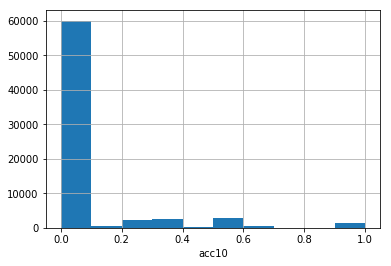

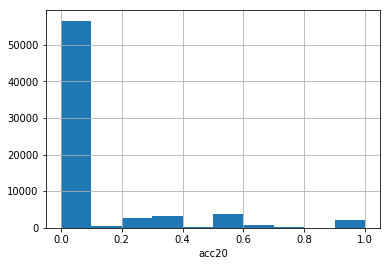

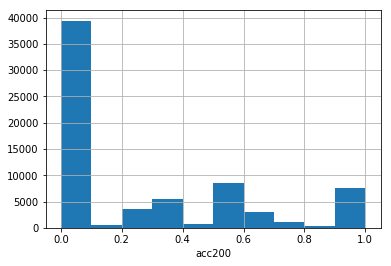

In [21]:
result = evaluate(test_preds, sims)

ax = result['acc10'].hist()
ax.set_xlabel("acc10")
plt.show()

ax = result['acc20'].hist()
ax.set_xlabel("acc20")
plt.show()

ax = result['acc200'].hist()
ax.set_xlabel("acc200")
plt.show()

In [24]:
k = test_preds.keys()[1]
print(k)
test_preds[k]

5984bd8ab6b11372fe638533


[u'5984b83eb6b1132dd6638555',
 u'5984c0a7b6b1131ae26384fa',
 u'5984b97eb6b113402263850a',
 u'5984bf85b6b11308e263853b',
 u'5984b5b3b6b1130679638512',
 u'5984b6f2b6b11319d0638511',
 u'5984db83b6b11321a463851a',
 u'5984b772b6b1132416638536',
 u'5984c9bcb6b1137ef0638524',
 u'5984c0b2b6b1131adb638548',
 u'5984bf9ab6b1130a4363850e',
 u'5984cc3eb6b1131a48638504',
 u'5984d113b6b11343016384f6',
 u'5984b6dab6b11318b3638524',
 u'5984b789b6b113255563850b',
 u'5984c60eb6b113559663851b',
 u'5984b9fcb6b11348a963851f',
 u'5984bc9cb6b11366b263854b',
 u'5984cd6db6b113234363852c',
 u'5984c084b6b11318c663854f',
 u'5984cbe6b6b11317a0638538',
 u'5984c0b0b6b1131ae1638528',
 u'5984b80ab6b1132b9c63852c',
 u'5984c155b6b1131fc3638527',
 u'5984c092b6b11319c2638526',
 u'5984c129b6b1131e6663853d',
 u'5984d43fb6b113638f638523',
 u'5984bcaeb6b11367e3638508',
 u'5984cbdfb6b11317ab638510',
 u'5984ccb6b6b1131d536384ef',
 u'5984b680b6b113148563851a',
 u'5984bcf6b6b1136a21638515',
 u'5984bda9b6b1137430638510',
 u'5984d0c

In [ ]:
predict([k], lim=10**9)[k].index('5984c081b6b11318b7638546')

# Develop

In [59]:
g = tf.Graph()
with g.as_default():
    tf.set_random_seed(0)
    sess = tf.Session()
    with sess.as_default():
        
        r = list(range(100))
        ziped = zip(r[:-1], r[1:])
        t = tf.convert_to_tensor(ziped)
        
        def f(el):
            return el[0]
        
#         elems = np.array([1, 2, 3, 4, 5, 6])
#         squares = tf.map_fn(lambda x: x * x, elems)

        
        m = tf.map_fn(f, t)
            
        sess.run(tf.global_variables_initializer())
        
        [res] = sess.run([m])
        print(res)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98]
